# From simulator to Inference with HDDM (LAN version)

This Tutorial serves as an example for a full LAN pipeline to inference with HDDM.
We start with a *simulator* of a *Sequential Sampling Model* (SSM), use it to generate training data for 
a *LAN*, train the *LAN* and then use **HDDM** to perform inference on a synthetic dataset from our *simulator*.

The example uses the simple DDM for illustration, you can switch out the DDM for your SSM of choice when utilizing this pipeline for your own work.

We will make use of two packages in the *LAN ecosystem* (installation instructions below), to help our process. 

1. The [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package, which holds a collection of fast simulators and training data generators for LANs
2. The [`LANfactory`](https://github.com/AlexanderFengler/LANfactory) package, which makes defining and training LANs convenient. 


The [`LANfactory`](https://github.com/AlexanderFengler/LANfactory) package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

**NOTE**:
The [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package directly generates training data as expected to train **LANs** as per the [`LAN-paper`](https://elifesciences.org/articles/65074).

### Install (colab)

In [129]:
# package to help train networks
# !pip install git+https://github.com/AlexanderFengler/LANfactory

# package containing simulators for ssms
# !pip install git+https://github.com/AlexanderFengler/ssm_simulators

# packages related to hddm
# !pip install cython
# !pip install pymc==2.3.8
# !pip install git+https://github.com/hddm-devs/kabuki
# !pip install git+https://github.com/hddm-devs/hddm

## Load Modules

In [26]:
# HDDM
import hddm

# Package to help train networks (explained above)
import lanfactory

# Package containing simulators for ssms (explained above)
import ssms

# Other misc packages
import os
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch

## Make Training Data

### Configs
To create the training data we need, we first specify a configuration dictionary (`generator_config` below), as expected by the `ssms.dataset_generator.data_generator()` function. 

**NOTE:**
Specific to `ssms` package. You can ignore this if you provide your own training data.

In [130]:
# MAKE CONFIGS
from ssms.config import data_generator_config

# Initialize the generator config (for MLP LANs)

# (We start from a supplied example in the ssms package)
generator_config = deepcopy(data_generator_config["lan"]["mlp"])

# Specify generative model (one from the list of included models in the ssms package)
generator_config["dgp_list"] = "ddm"

# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 5000

# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000

# Specify how many training examples to extract from
# a single parametervector
generator_config["n_training_examples_by_parameter_set"] = 2000

# Specify folder in which to save generated data
generator_config["output_folder"] = "lan_to_hddm_tmp_data/lan_mlp/"

# Make model config dict
model_config = ssms.config.model_config["ddm"]

# Show
model_config

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['z'],
 'nchoices': 2}

### Run Simulator 

The `generate_data_training_uniform()` function generates training data as expected by the `LANfactory` package for LAN training.

In [128]:
# MAKE DATA
my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

training_data = my_dataset_generator.generate_data_training_uniform(save=True)

checking:  lan_to_hddm_tmp_data/lan_mlp/
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  lan_to_hddm_tmp_data/lan_mlp/training_data_0_nbins_0_n_2000/ddm/training_data_ddm_9ff20d34691a11ed8cc7acde48001122.pickle


## Train Network

### Data Loaders

The `LANfactory` package provides some convenience functions to create so-called `data loaders` (finally `DataLoader` `class` in `PyTorch`). These help with making neural network training efficient, when loading training data from file.

In [2]:
# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = "lan_to_hddm_tmp_data/lan_mlp/training_data_0_nbins_0_n_2000/ddm/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(
    file_IDs=file_list_, batch_size=128
)

torch_training_dataloader = torch.utils.data.DataLoader(
    torch_training_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_IDs=file_list_, batch_size=128
)

torch_validation_dataloader = torch.utils.data.DataLoader(
    torch_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

### Network Config

`LANfactory` networks take in a `network_config` dictionary, which specifies the *network architecture*.
This is necessary to construct our network from the `lanfactory.trainer.TorchMLP` class.

In [5]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS

network_config = lanfactory.config.network_configs.network_config_mlp

print("Network config: ")
print(network_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


### Train Config

To train a network with the `LANfactory` package, we have to specify a `train_config` dictionary, which contains the necessary *training hyperparameters*. In the `config.network_configs` module,  an example is provided, which we slightly adapt.

In [133]:
from lanfactory.config.network_configs import train_config_mlp

train_config_mlp

{'cpu_batch_size': 128,
 'gpu_batch_size': 256,
 'n_epochs': 5,
 'optimizer': 'adam',
 'learning_rate': 0.002,
 'lr_scheduler': 'reduce_on_plateau',
 'lr_scheduler_params': {},
 'weight_decay': 0.0,
 'loss': 'huber',
 'save_history': True}

In [134]:
train_config = deepcopy(train_config_mlp)
train_config["save_history"] = False

print("Train config: ")
print(train_config)

Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': False}


### Initialize Network

We can now initialize the network using the `TorchMLP` class provided in the `LANfactory` package.

In [ ]:
from lanfactory.trainers import TorchMLP

# LOAD NETWORK
net = TorchMLP(
    network_config=deepcopy(network_config),
    input_shape=torch_training_dataset.input_dim,
    save_folder="lan_to_hddm_tmp_data/lan_mlp/",
    generative_model_id="ddm",
)

# SAVE CONFIGS
lanfactory.utils.save_configs(
    model_id=net.model_id + "_torch_",
    save_folder="lan_to_hddm_tmp_data/lan_mlp/",
    network_config=network_config,
    train_config=train_config,
    allow_abs_path_folder_generation=True,
)

We pass the `train_config` dictionary, our network `net` and the dataloaders to the `ModelTrainerTorchMLP` class from the `LANfactory` package, after which we can train our model with a simple call to the `train_model()` function.

In [6]:
# TRAIN MODEL
model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(
    train_config=train_config,
    data_loader_train=torch_training_dataloader,
    data_loader_valid=torch_validation_dataloader,
    model=net,
    output_folder="lan_to_hddm_tmp_data/lan_mlp/",
)

model_trainer.train_model(save_history=False, save_model=True, verbose=0)

Torch Device:  cpu
Found folder:  lan_to_hddm_tmp_data
Moving on...
Found folder:  lan_to_hddm_tmp_data/lan_mlp
Moving on...
wandb not available, not storing results there
Epoch took 0 / 5,  took 136.11848092079163 seconds
epoch 0 / 5, validation_loss: 0.03961
Epoch took 1 / 5,  took 113.36870789527893 seconds
epoch 1 / 5, validation_loss: 0.04193
Epoch took 2 / 5,  took 112.76040506362915 seconds
epoch 2 / 5, validation_loss: 0.03371
Epoch took 3 / 5,  took 109.81652188301086 seconds
epoch 3 / 5, validation_loss: 0.03548
Epoch took 4 / 5,  took 111.44894003868103 seconds
epoch 4 / 5, validation_loss: 0.03456
Saving model state dict
Training finished successfully...


## Use in HDDM

We generated training data from model simulations, and trained our LAN.

Let's proceed to use our freshly minted LAN in HDDM for inference on our *custom model* (as a reminder, this was mundanely just a DDM for purposes of this tutorial).

### Define HDDM Model Config

The `HDDMnn()` classes generally expect a `model_config` dictionary which specifies details about parameters names, allowed parameters values and other aspects of a given SSM. 

If a valid *model string* is provided as an argument, HDDM will supply the appropriate `model_config` (and respective LAN) internally from the model bank that is already included in the package. 

Instead, we can supply a custom `model_config`, as well as a custom *likelihood* (via the `network` argument), with very few a priori restrictions. 

We will now define such a custom `model_config` and then show how to provide our LAN trained above as a custom likelihood, after which we can sample from our custom HDDM model.

In [84]:
my_model_config = {}

# Parameter names associated to your model
my_model_config["params"] = ["v", "a", "z", "t"]

# The parameter boundaries you used for training your LAN
my_model_config["param_bounds"] = [[-3.0, 0.3, 0.1, 1e-3], [3.0, 2.5, 0.9, 2.0]]

# Suggestion for which parameters to include
# via the include statement of an HDDM model
# (usually you want all of the parameters from above)
my_model_config["hddm_include"] = ["v", "a", "z", "t"]

# choice labels (what your simulator spits out)
my_model_config["choices"] = [-1, 1]

In [85]:
# Specifies parameters which the sampler should tansform (optional)
my_model_config["params_trans"] = [0, 0, 0, 0]

# adds sampler settings for each parameter
# (optional: Can improve sampler speed if informed decision made here)
my_model_config["slice_widths"] = {
    "v": 1.5,
    "v_std": 1,
    "a": 1,
    "a_std": 1,
    "z": 0.1,
    # "z_trans": 0.2,
    "z_std": 0.2,
    "t": 0.01,
    "t_std": 0.15,
}

# Default values for parameters
# (Useful if you don't intend to fit one or more of them)
my_model_config["params_default"] = [0.0, 1.0, 0.5, 1e-3]

# Set a (reasonable) upper limit of group level standard deviations,
# (optional: Can help with sampler stability)
my_model_config["params_std_upper"] = [1.5, 1.0, None, 1.0]

### Load the Network 

The `LoadTorchMLPInfer()` function is used to load a network in inference mode. We explain more below.

In [86]:
from lanfactory.trainers import LoadTorchMLPInfer

net = LoadTorchMLPInfer(
    model_file_path="lan_to_hddm_tmp_data/lan_mlp/"
    + "2d4eedae67b911ed8acaacde48001122_ddm_torch_state_dict.pt",
    network_config=network_config,
    input_dim=6,
)

tanh
tanh
linear


The `LoadTorchMLPInfer()` class loads our network in `eval` mode and stops gradients from being accumulated. 
Importantly, it exposes a `predict_on_batch()` method, which is what HDDM will call internally. 

The naming of this function is a left-over from `keras` days, however what it does internally may be important if you would like to supply a fully custom likelihood at some point.

In [ ]:
# A look at the internals
from lanfactory.trainers import TorchMLP


class LoadTorchMLPInfer:
    def __init__(self, model_file_path=None, network_config=None, input_dim=None):
        torch.backends.cudnn.benchmark = True
        self.dev = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )
        self.model_file_path = model_file_path
        self.network_config = network_config
        self.input_dim = input_dim

        self.net = TorchMLP(
            network_config=self.network_config,
            input_shape=self.input_dim,
            generative_model_id=None,
        )
        self.net.load_state_dict(torch.load(self.model_file_path))
        self.net.to(self.dev)
        self.net.eval()

    @torch.no_grad()
    def __call__(self, x):
        return self.net(x)

    @torch.no_grad()
    def predict_on_batch(self, x=None):
        return self.net(torch.from_numpy(x).to(self.dev)).cpu().numpy()

The argument `x`, to the `predict_on_batch()`, when called from within HDDM's sampler, will be a matrix. 
Rows correspond to trials, and columns are supplied in the following way. 

The first few columns contain trial wise parameters (in the order specific in the `model_config` above under the `"params"` `key`).
The last two columns contain the trial wise *reaction times* and *choices* respectively.

To understand better how HDDM calls such a custom likelihood *internally*, see the code below.

**NOTE:**
Don't run the cell below, it is just for illustration!

In [ ]:
def wiener_like_nn_mlp_pdf(np.ndarray[float, ndim = 1] rt,
                           np.ndarray[float, ndim = 1] response,
                           np.ndarray[float, ndim = 1] params,
                           double p_outlier = 0, 
                           double w_outlier = 0,
                           bint logp = 0,
                           network = None):
    
    cdef Py_ssize_t size = rt.shape[0]
    cdef Py_ssize_t n_params = params.shape[0]

    cdef np.ndarray[float, ndim = 1] log_p = np.zeros(size, dtype = np.float32)
    cdef float ll_min = -16.11809

    cdef np.ndarray[float, ndim = 2] data = np.zeros((size, n_params + 2), dtype = np.float32)
    data[:, :n_params] = np.tile(params, (size, 1)).astype(np.float32)
    data[:, n_params:] = np.stack([rt, response], axis = 1)

    # Call to network:
    if p_outlier == 0: 
        log_p = np.squeeze(np.core.umath.maximum(network.predict_on_batch(data), ll_min))
    else: 
        log_p = np.squeeze(np.log(np.exp(np.core.umath.maximum(network.predict_on_batch(data), ll_min)) * (1.0 - p_outlier) + (w_outlier * p_outlier)))
    if logp == 0:
        log_p = np.exp(log_p)
    return log_p

We see that the *internal likelihood function* expects a network as input and then finally calls the `predict_on_batch()` to get log-likelihoods. 

### Generate Example Dataset

We can now generate an example dataset and use our newly created LAN to fit our custom DDM to the data.

In [121]:
# Choose some parameters
v = 0.9
a = 1.4
z = 0.45
t = 0.7

# Simulate Data
data = ssms.basic_simulators.simulator(model="ddm", theta=[v, a, z, t], n_samples=500)

# Bring into correct shape expected from HDDM
data_df = pd.DataFrame(
    np.stack([data["rts"], data["choices"]], axis=1)[:, :, 0],
    columns=["rt", "response"],
)
data_df["subj_idx"] = 0
data_df["v"] = v
data_df["a"] = a
data_df["z"] = z
data_df["t"] = t


data_df

,rt,response,subj_idx,v,a,z,t
0,1.133998,1.0,0,0.9,1.4,0.45,0.7
1,1.774994,1.0,0,0.9,1.4,0.45,0.7
2,2.028006,1.0,0,0.9,1.4,0.45,0.7
3,1.188997,1.0,0,0.9,1.4,0.45,0.7
4,1.822996,1.0,0,0.9,1.4,0.45,0.7
...,...,...,...,...,...,...,...
495,1.944002,1.0,0,0.9,1.4,0.45,0.7
496,1.384995,1.0,0,0.9,1.4,0.45,0.7
497,0.967000,1.0,0,0.9,1.4,0.45,0.7
498,3.996943,1.0,0,0.9,1.4,0.45,0.7


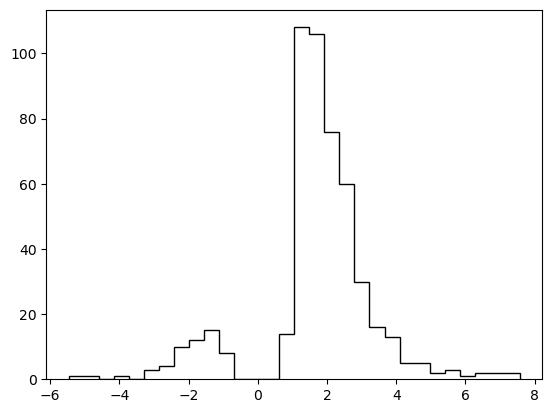

In [122]:
# Plotting the RTs
plt.hist(
    data_df["rt"] * data_df["response"],
    histtype="step",
    color="black",
    density=True,
    bins=30,
)
plt.xlabel("Reaction Time")
plt.ylabel("Density")
plt.show()

### Define HDDM Model

In [123]:
# Define the HDDM model
hddmnn_model = hddm.HDDMnn(
    data=data_df,
    informative=False,
    include=my_model_config["hddm_include"],
    model_config=my_model_config,
    network=net,
)

Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


### Sample

In [124]:
hddmnn_model.sample(1000, burn=500)

 [-----------------100%-----------------] 1000 of 1000 complete in 71.1 sec

In [125]:
tmp = hddmnn_model.gen_stats()
tmp["ground_truth"] = data_df.iloc[0, 3:]
tmp[["ground_truth", "mean", "std"]]

,ground_truth,mean,std
v,0.90,1.001513,0.065515
a,1.40,1.327698,0.056254
z,0.45,0.435518,0.022863
t,0.70,0.765093,0.041211


### Plots

We show two plots. *First*, we compare simulations fixing the parameters at the posterior mean with the original data, to get a visual idea of the model fit we obtained. *Second* we show the posterior traces.

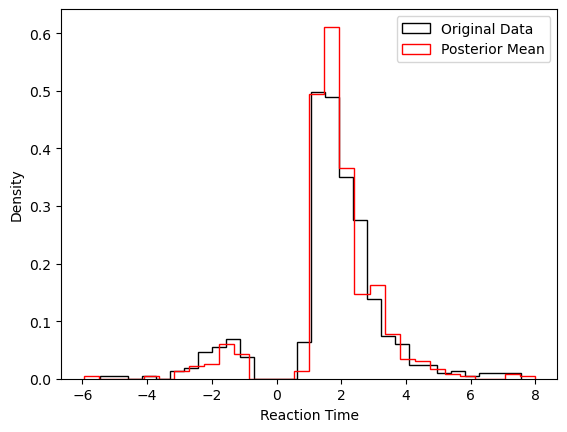

In [127]:
# Compare simulations from posterior mean parameters
# to original data
data_post_mean = data = ssms.basic_simulators.simulator(
    model=model, theta=list(tmp["mean"].values), n_samples=500
)


# Plotting the RTs
plt.hist(
    data_df["rt"] * data_df["response"],
    histtype="step",
    color="black",
    density=True,
    bins=30,
    label="Original Data",
)
plt.hist(
    data_post_mean["rts"] * data_post_mean["choices"],
    histtype="step",
    color="red",
    density=True,
    bins=30,
    label="Posterior Mean",
)
plt.xlabel("Reaction Time")
plt.ylabel("Density")
plt.legend()
plt.show()

Plotting v
Plotting a
Plotting z
Plotting t


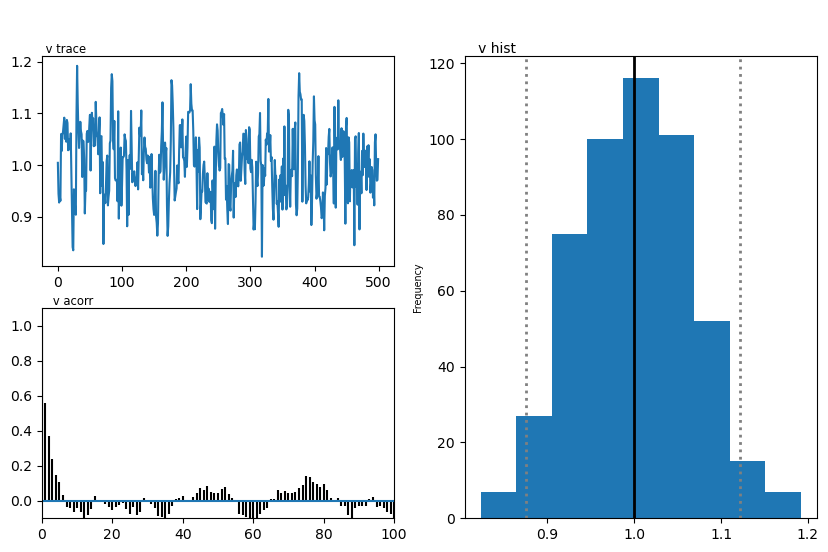

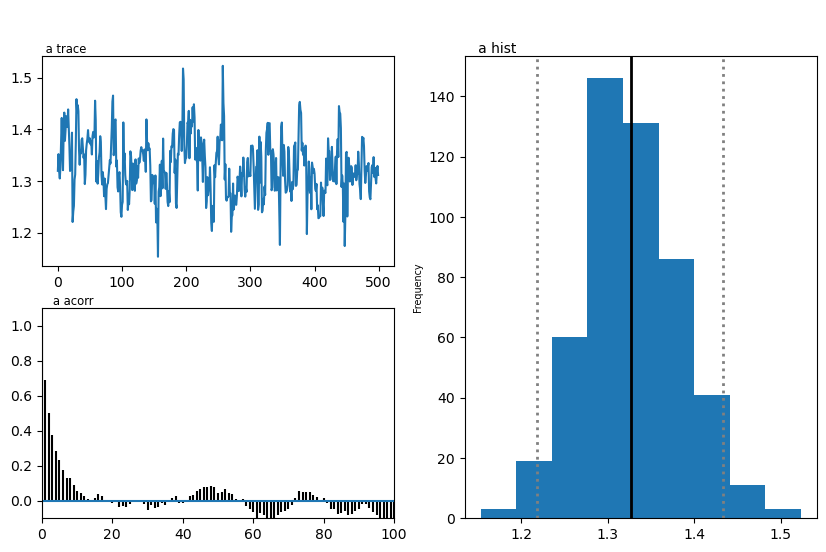

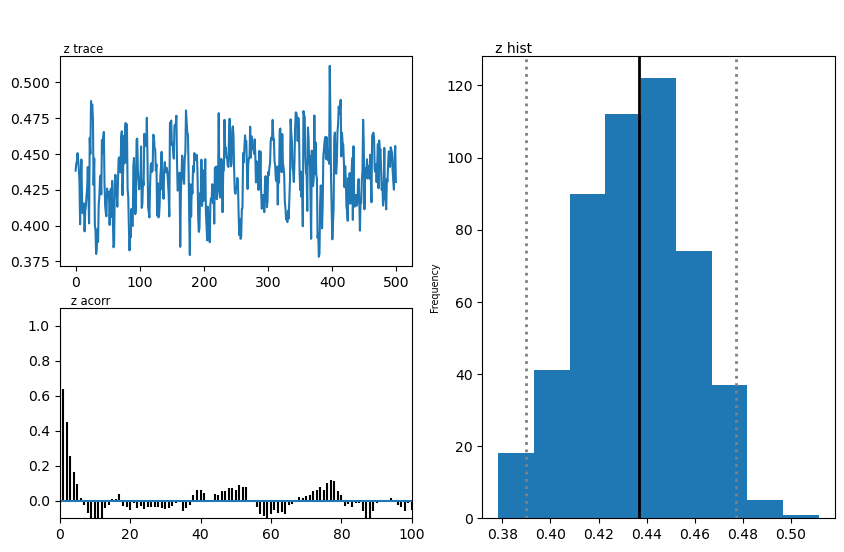

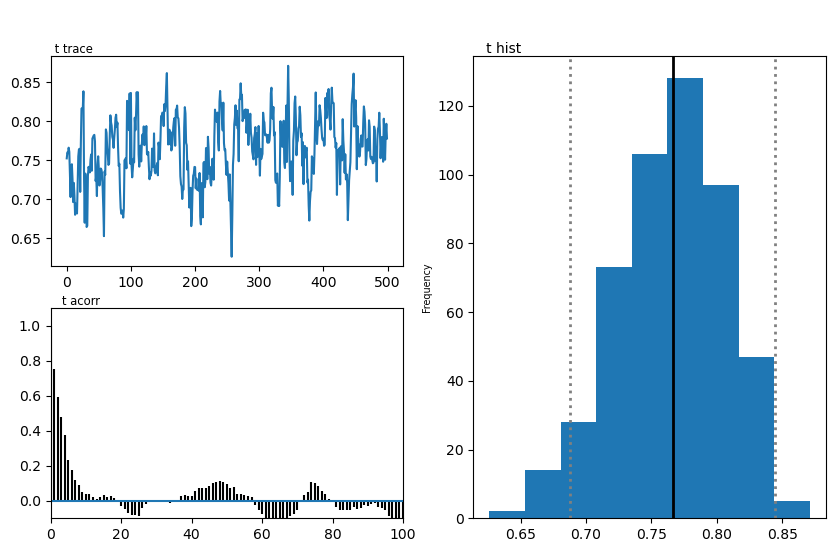

In [126]:
import matplotlib
import matplotlib.pyplot as plt

hddmnn_model.plot_posteriors()
plt.show()

**END**